# Brain Tumor MRI Classification Using ResNet101

## Data Loading

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 98% 145M/149M [00:04<00:00, 42.0MB/s]
100% 149M/149M [00:04<00:00, 35.0MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/brain-tumor-mri-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import warnings
warnings.filterwarnings("ignore")

In [5]:
classes=[]
filename='/content'
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)

['meningioma', 'glioma', 'notumor', 'pituitary']


In [6]:
train_path='/content/Training'
test_path='/content/Testing'

In [7]:
img_list=[]
label_list=[]
for label in classes:
    for img_file in os.listdir(os.path.join(train_path, label)):
        img_list.append(os.path.join(train_path, label, img_file))
        label_list.append(label)

In [8]:
train_data = pd.DataFrame({'Image':img_list,'Label':label_list})
train_data

,Image,Label
0,/content/Training/meningioma/Tr-me_1245.jpg,meningioma
1,/content/Training/meningioma/Tr-me_0590.jpg,meningioma
2,/content/Training/meningioma/Tr-me_0153.jpg,meningioma
3,/content/Training/meningioma/Tr-me_0130.jpg,meningioma
4,/content/Training/meningioma/Tr-me_0024.jpg,meningioma
...,...,...
5707,/content/Training/pituitary/Tr-pi_1392.jpg,pituitary
5708,/content/Training/pituitary/Tr-pi_1049.jpg,pituitary
5709,/content/Training/pituitary/Tr-pi_0248.jpg,pituitary
5710,/content/Training/pituitary/Tr-pi_0790.jpg,pituitary


In [9]:
img_list=[]
label_list=[]
for label in classes:
    for img_file in os.listdir(os.path.join(test_path, label)):
        img_list.append(os.path.join(test_path, label, img_file))
        label_list.append(label)

In [10]:
test_data = pd.DataFrame({'Image':img_list,'Label':label_list})
test_data

,Image,Label
0,/content/Testing/meningioma/Te-me_0208.jpg,meningioma
1,/content/Testing/meningioma/Te-me_0151.jpg,meningioma
2,/content/Testing/meningioma/Te-me_0046.jpg,meningioma
3,/content/Testing/meningioma/Te-me_0112.jpg,meningioma
4,/content/Testing/meningioma/Te-me_0034.jpg,meningioma
...,...,...
1306,/content/Testing/pituitary/Te-pi_0140.jpg,pituitary
1307,/content/Testing/pituitary/Te-pi_0011.jpg,pituitary
1308,/content/Testing/pituitary/Te-pi_0269.jpg,pituitary
1309,/content/Testing/pituitary/Te-piTr_0007.jpg,pituitary


In [11]:
print(f'Train Data Shape: {train_data.shape}')
print(f'Test Data Shape: {test_data.shape}')

Train Data Shape: (5712, 2)
Test Data Shape: (1311, 2)


## Data Visualization

In [12]:
def Plot_Classes(BASE_URL, Rows=2, Columns=5):

    plt.figure(figsize=(25, 8))
    image_count = 1

    for directory in os.listdir(BASE_URL):
        if directory[0] != '.':
            directory_path = os.path.join(BASE_URL, directory)
            Max_Random = len(os.listdir(directory_path))
            Random_Number = np.random.randint(0, Max_Random)

            for i, file in enumerate(os.listdir(directory_path)):
                if i == Random_Number:
                    fig = plt.subplot(Rows, Columns, image_count)
                    image_count += 1

                    image_path = os.path.join(directory_path, file)
                    image = plt.imread(image_path)
                    plt.imshow(image)

                    plt.title(directory)
                    break

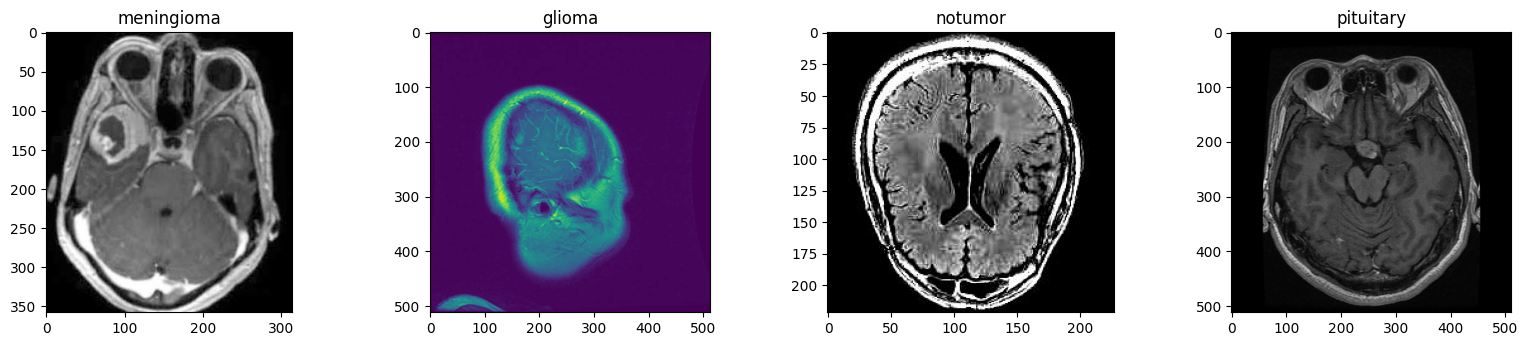

In [13]:
Plot_Classes(train_path)

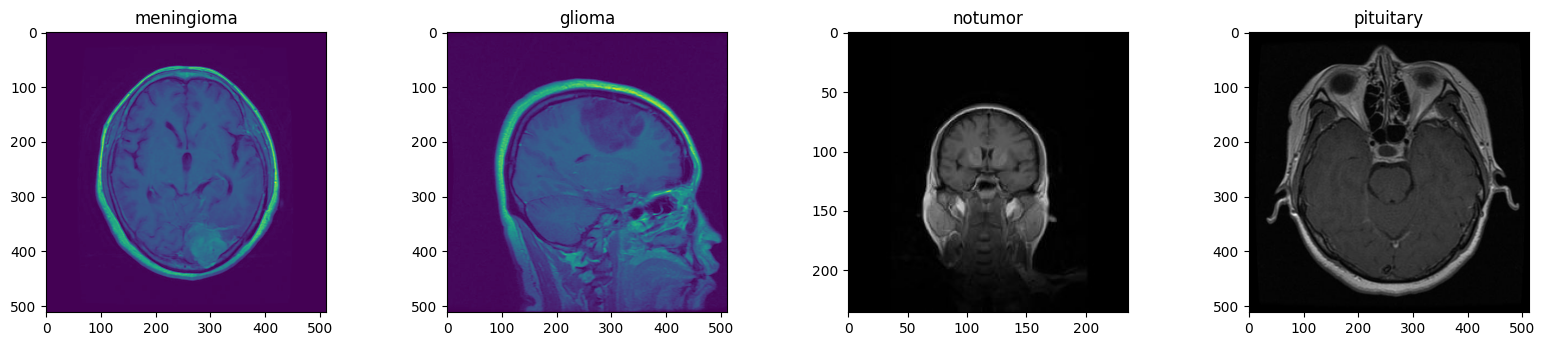

In [14]:
Plot_Classes(test_path)

In [15]:
train_data['Label'].value_counts()

,count
Label,
notumor,1595
pituitary,1457
meningioma,1339
glioma,1321


<Axes: xlabel='Label'>

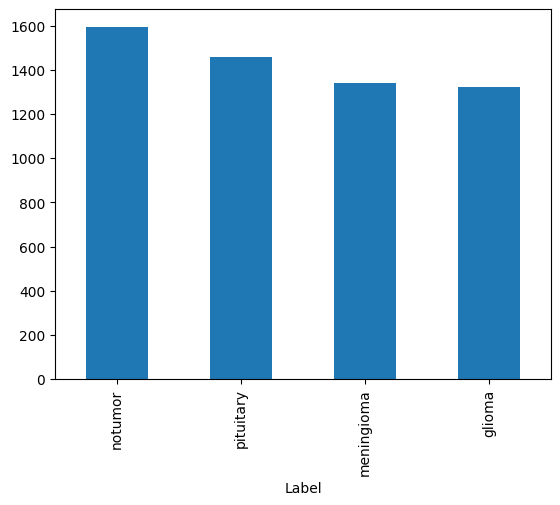

In [16]:
train_data['Label'].value_counts().plot(kind='bar')

In [17]:
test_data['Label'].value_counts()

,count
Label,
notumor,405
meningioma,306
glioma,300
pituitary,300


<Axes: xlabel='Label'>

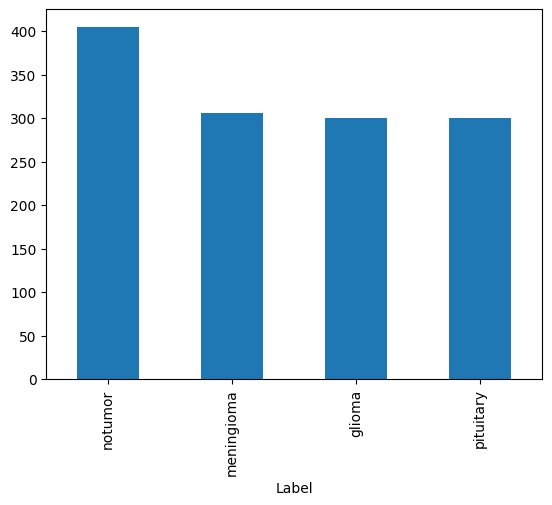

In [18]:
test_data['Label'].value_counts().plot(kind='bar')

## Data Preprocessing

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [20]:
image_size = (150, 150)
batch_size = 32

In [21]:
# Data Augmentation


train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.15,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)

# Training data generator
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    seed=0)

# Validation data generator
val_generator = val_datagen.flow_from_directory(train_path,
                                                target_size=image_size,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                subset='validation',
                                                seed=0)

# Rescaling test data
test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=0)

Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [22]:
# Function to viusalize how the ImageDataGenerator augments the data

def show_ImageDataGenerator(ImageDataGenerator, num_samples=5, figsize=(12, 12), save=False):

    augmented_samples = train_generator.__next__()
    images = augmented_samples[0][:num_samples]
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')

    plt.tight_layout()
    if save:
        plt.savefig('show_ImageDataGenerator.pdf')
    plt.show()

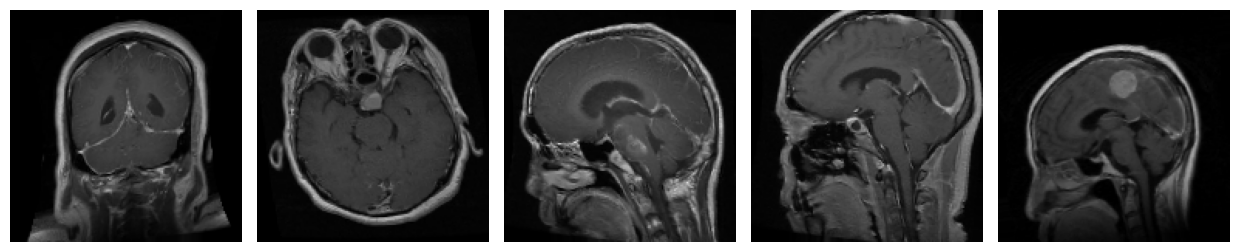

In [23]:
show_ImageDataGenerator(train_datagen, num_samples=5, figsize=(12.5, 8), save=False)

In [24]:
image_shape = (image_size[0], image_size[1], 3)

print(f'Image shape: {image_shape}')
print(f'Batch size: {batch_size}')
print(f'Number of Train batches: {len(train_generator)}')
print(f'Number of Validation batches: {len(val_generator)}')
print(f'Number of Testing batches: {len(test_generator)}')

Image shape: (150, 150, 3)
Batch size: 32
Number of Train batches: 152
Number of Validation batches: 27
Number of Testing batches: 41


In [25]:
# Mapping the labels

Classes_Map = train_generator.class_indices
num_classes = len(Classes_Map)
print("Number of Classes:", num_classes)
Classes_Map

Number of Classes: 4


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

## Model Building

In [42]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [29]:
base_model_resnet = ResNet101(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [30]:
# Adding custom classification head

x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)

In [31]:
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

In [32]:
model_resnet = Model(inputs=base_model_resnet.input, outputs=output)

In [33]:
model_resnet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
model_resnet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 43,709,316 (166.74 MB)

 Trainable params: 43,603,972 (166.34 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [35]:
history = model_resnet.fit(train_generator,epochs=10,validation_data=val_generator)

Epoch 1/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 220s 728ms/step - accuracy: 0.8101 - loss: 0.5030 - val_accuracy: 0.2982 - val_loss: 5.1971
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 58s 372ms/step - accuracy: 0.9621 - loss: 0.1246 - val_accuracy: 0.3029 - val_loss: 1.9697
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 81s 361ms/step - accuracy: 0.9725 - loss: 0.0890 - val_accuracy: 0.2807 - val_loss: 3.5837
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 82s 366ms/step - accuracy: 0.9723 - loss: 0.0804 - val_accuracy: 0.2468 - val_loss: 6.1758
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 57s 364ms/step - accuracy: 0.9763 - loss: 0.0716 - val_accuracy: 0.5719 - val_loss: 1.1369
Epoch 6/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.9852 - loss: 0.0443 - val_accuracy: 0.7766 - val_loss: 0.5893
Epoch 7/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 56s 360ms/step - accuracy: 0.9904 - loss: 0.0302 - val_accuracy: 0.9158 - val_loss: 0.2741
Epoch 8/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 57s 365ms/step - accuracy: 0.9882 - loss: 

## Model Evaluation

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.figure(figsize=(15,5))
  plt.style.use('ggplot')


  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, 'bo-' , label = "TrainL oss")
  plt.plot(epochs, val_loss, 'o-' , color='orange', label = "Val Loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()


  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, 'bo-' , label = "Train Acc")
  plt.plot(epochs, val_accuracy, 'o-' , color='orange' , label = "Val Acc")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()

  plt.style.use('default')

In [27]:
def CM(model, test_generator, categories):
    """
    Function to return the confusion matrix of a given CNN model.
    """
    from sklearn.metrics import confusion_matrix
    # Predictions on test dataset
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Create a confusion matrix
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)
    print(f"Classification Report for {model}:")
    print(classification_report(true_categories, predicted_categories, target_names=categories))

    return confusion_matrix_array


def calculate_metrics(confusion_matrix, categories):
    """
    Function to calculate important metrics for multi-classification problems.
    """
    # Calculating 4 different metrics
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Printing the results based on each category
    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")

    # Showing the total accuracy of the model
    print(f"\nAccuracy: {accuracy:.3f}")

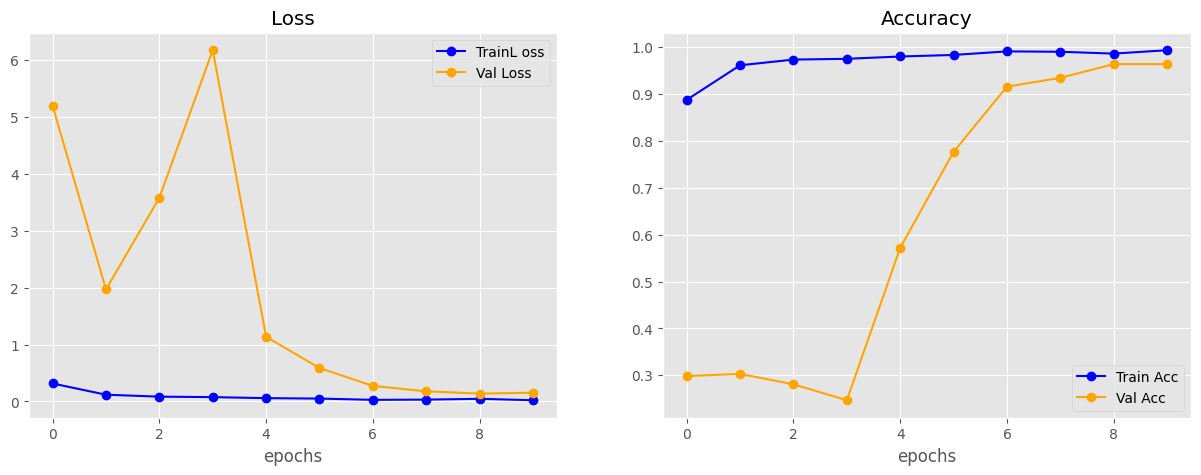

In [36]:
plot_curves(history)

In [37]:
loss, accuracy = model_resnet.evaluate(test_generator)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.9830 - loss: 0.0666
Test Loss: 0.05583
Test Accuracy: 0.98474


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
Classification Report for <Functional name=functional, built=True>:
              precision    recall  f1-score   support

  meningioma       0.99      1.00      1.00       300
      glioma       1.00      0.94      0.97       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.96      1.00      0.98       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.99      0.98      0.98      1311



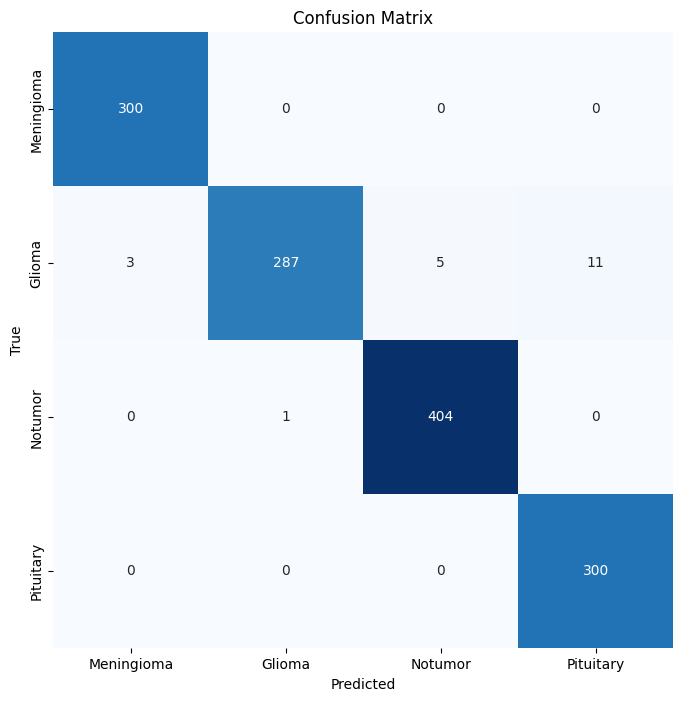

In [40]:
confusion_matrix = CM(model=model_resnet, test_generator=test_generator, categories=classes)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in classes], va='center')
plt.show()

{'meningioma': 100.0, 'glioma': 0.0, 'notumor': 0.0, 'pituitary': 0.0}
{'meningioma': 100.0, 'glioma': 0.0, 'notumor': 0.0, 'pituitary': 0.0}
{'meningioma': 100.0, 'glioma': 0.0, 'notumor': 0.0, 'pituitary': 0.0}
{'meningioma': 100.0, 'glioma': 0.0, 'notumor': 0.0, 'pituitary': 0.0}
{'meningioma': 100.0, 'glioma': 0.0, 'notumor': 0.0, 'pituitary': 0.0}
{'meningioma': 99.865, 'glioma': 0.1, 'notumor': 0.022, 'pituitary': 0.012}
{'meningioma': 100.0, 'glioma': 0.0, 'notumor': 0.0, 'pituitary': 0.0}
{'meningioma': 100.0, 'glioma': 0.0, 'notumor': 0.0, 'pituitary': 0.0}
{'meningioma': 99.989, 'glioma': 0.0, 'notumor': 0.001, 'pituitary': 0.01}
{'meningioma': 100.0, 'glioma': 0.0, 'notumor': 0.0, 'pituitary': 0.0}


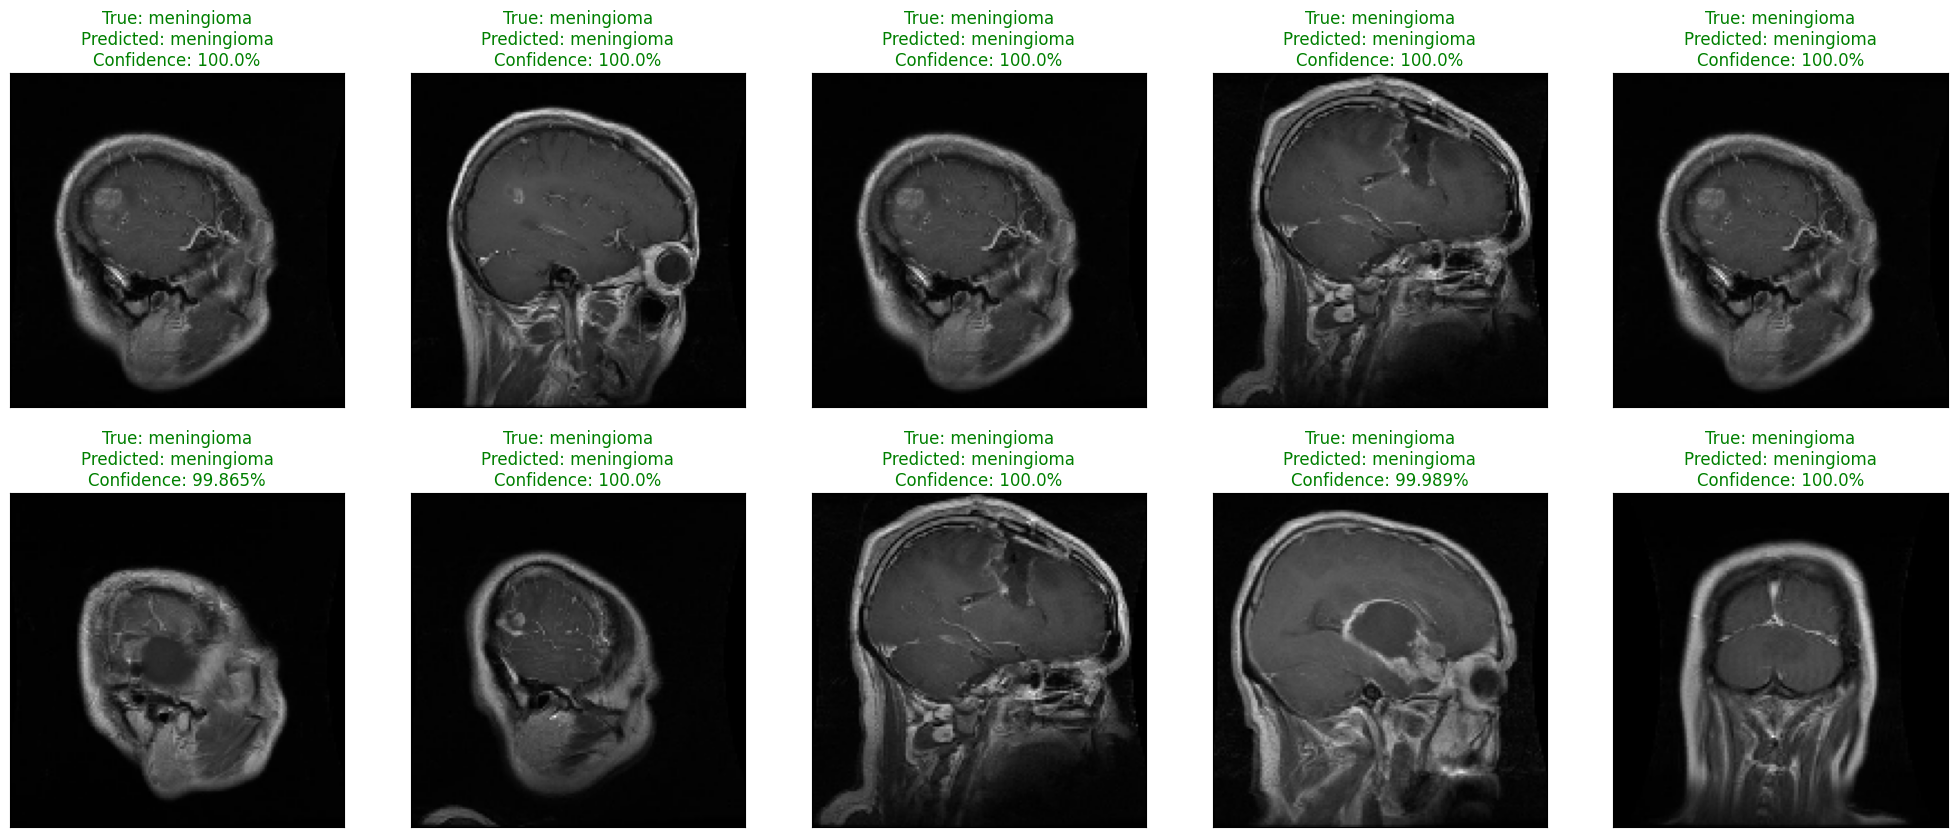

<Figure size 640x480 with 0 Axes>

In [44]:
Random_batch = np.random.randint(0, len(test_generator))
Random_Img_Index = np.random.randint(0, batch_size , 10)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])
    Model_Predictions = model_resnet.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0)
    Model_Highest_Prediction = np.argmax(Model_Predictions)
    Model_Predictions_Map = { c: round(p*100,3) for (c,p) in zip (classes, Model_Predictions.tolist()[0] ) }
    ax.imshow(Random_Img)

    Pred_Class = classes[Model_Highest_Prediction]
    if classes[Random_Img_Label] == Pred_Class:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {classes[Random_Img_Label]}\nPredicted: {Pred_Class}\nConfidence: {Model_Predictions_Map[Pred_Class]}%",
          color=color)
    print(Model_Predictions_Map)
plt.show()
plt.tight_layout()